In [1]:
import pandas as pd

df_factor = pd.read_csv("C:/Users/woota/OneDrive/Desktop/새 폴더/Personal projects/HMM ML strategy/panel_data.xlsx", parse_dates=["date"])
df_macro = pd.read_csv("C:/Users/woota/OneDrive/Desktop/새 폴더/Personal projects/HMM ML strategy/regime_data.csv", parse_dates=["date"])

## HMM Training

In [2]:
import numpy as np
import pandas as pd
import pickle
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ============================================================
# Config
# ============================================================
IS_START = "2000-01-01"
IS_END   = "2016-12-31"
OOS_START= "2017-01-01"
OOS_END  = "2024-12-31"

# Warm-up fill for probabilities: "backfill_first" | "stationary" | "none"
FILL_STRATEGY = "backfill_first"

# Optional smoothing (set to 0 to disable)
EMA_SPAN = 3  # months; 0 disables

# Binary label threshold for regime-on
REGIME_THRESHOLD = 0.5

# Sticky transition prior (high self-transition)
STICKY_DIAG = 0.97

# Save learned parameters here (set to None to skip)
SAVE_PATH = "hmm_regime_params.pkl"

# ============================================================
# Observable features
#   Default: realized vol only (negative weight => risk-off)
#   Extend FEATURES and FEATURE_WEIGHTS if you want a composite signal.
# ============================================================
FEATURES = [
    "mkt_realized_vol",  # 3m realized vol, annualized
]
FEATURE_WEIGHTS = {
    "mkt_realized_vol": -1.0,  # higher vol = more risk-off
}

# ============================================================
# Prep data
#   Expect df_macro with 'date' and FEATURES columns.
#   Keep IS/OOS masks for later truncation.
# ============================================================
df_macro = df_macro.copy()
df_macro["date"] = pd.to_datetime(df_macro["date"])
df_macro = df_macro.sort_values("date").reset_index(drop=True)

is_mask  = (df_macro["date"] >= IS_START) & (df_macro["date"] <= IS_END)
oos_mask = (df_macro["date"] >= OOS_START) & (df_macro["date"] <= OOS_END)

# ============================================================
# Helpers
# ============================================================
def stationary_dist(T):
    vals, vecs = np.linalg.eig(T.T)
    idx = np.argmin(np.abs(vals - 1.0))
    v = np.real(vecs[:, idx])
    v = np.maximum(v, 0)
    v = v / v.sum() if v.sum() != 0 else np.ones_like(v) / len(v)
    return v

def fill_warmup(series, strategy, model=None, state_idx=None):
    s = series.copy()
    fv = s.first_valid_index()
    if fv is None:
        return s
    if strategy == "backfill_first":
        s.iloc[:fv+1] = s.iloc[fv]
    elif strategy == "stationary" and (model is not None) and (state_idx is not None):
        pi = stationary_dist(model.transmat_)
        s.iloc[:fv+1] = float(pi[state_idx])
    return s

def maybe_smooth(series, span):
    if not span or span <= 1:
        return series
    return series.ewm(span=span, adjust=False, min_periods=1).mean()

def fit_binary_hmm(df, features, is_mask, cov_type="full", random_state=42):
    """
    Fit a 2-state HMM on IS valid rows (after standardizing on IS).
    Initializes a sticky transition matrix before EM.
    Returns: model, scaler, is_valid_mask (within IS)
    """
    is_X = df.loc[is_mask, features]
    is_valid = is_X.notna().all(axis=1)
    X_is = is_X.loc[is_valid].values
    if X_is.shape[0] < 10:
        raise ValueError(f"Not enough IS rows to fit HMM. Have {X_is.shape[0]}.")

    scaler = StandardScaler()
    X_is_scaled = scaler.fit_transform(X_is)

    # Initialize sticky HMM; let EM update transitions as well.
    model = GaussianHMM(
        n_components=2,
        covariance_type=cov_type,
        random_state=random_state,
        # params: which to update during EM; keep default "stmc" to update all
        # init_params: which to initialize before EM; we'll set transmat_ manually after constructing
    )

    # Startprob: neutral; Transmat: sticky
    model.startprob_ = np.array([0.5, 0.5])
    off = 1.0 - STICKY_DIAG
    model.transmat_ = np.array([[STICKY_DIAG, off],
                                [off, STICKY_DIAG]])

    # Fit on IS (scaled)
    model.fit(X_is_scaled)
    return model, scaler, is_valid

def map_states_to_regime_on(model, features, feature_weights, scaler):
    """
    Decide which hidden state = 'regime-on' by scoring state means with FEATURE_WEIGHTS.
    Transform model.means_ (which are in scaled space) back to original feature space.
    """
    state_means_scaled = model.means_  # (2, n_features)
    state_means = scaler.inverse_transform(state_means_scaled)
    w = np.array([feature_weights.get(f, 0.0) for f in features])
    scores = state_means @ w  # higher => more risk-on
    regime_on_state = int(np.argmax(scores))
    return regime_on_state, scores, state_means

def compute_smoothed_posteriors(df, model, scaler, features):
    """
    Smoothed posteriors over the entire span (research).
    """
    X = df[features]
    valid = X.notna().all(axis=1)
    out = np.full((len(df), model.n_components), np.nan, dtype=float)
    if valid.any():
        X_scaled = scaler.transform(X.loc[valid].values)
        out_valid = model.predict_proba(X_scaled)  # uses all data (smoothing)
        out[valid, :] = out_valid
    return out

def compute_filtered_posteriors(df, model, scaler, features):
    """
    Filtered posteriors (prefix-only) for live-like scoring.
    Implementation: run predict_proba on prefixes up to t, take last row.
    Complexity: O(T^2) but fine for monthly data.
    """
    X = df[features]
    valid = X.notna().all(axis=1)
    out = np.full((len(df), model.n_components), np.nan, dtype=float)
    if not valid.any():
        return out

    # Work on valid indices in order
    idxs = np.flatnonzero(valid.values)  # positions in df
    # Pre-transform all valid rows once
    X_scaled_all = scaler.transform(X.loc[valid].values)

    # Map df index -> compact valid index
    pos_map = {df_index: i for i, df_index in enumerate(np.where(valid)[0])}

    for k, pos in enumerate(idxs):
        # prefix up to this valid point in the compact array
        compact_end = pos_map[pos] + 1
        X_prefix = X_scaled_all[:compact_end]
        post_prefix = model.predict_proba(X_prefix)   # smoothed on prefix == filtered at last step
        out[pos, :] = post_prefix[-1, :]
    return out

def save_params(path, model, scaler, features, meta=None):
    payload = {
        "features": list(features),
        "scaler_mean_": scaler.mean_.copy(),
        "scaler_scale_": scaler.scale_.copy(),
        "startprob_": model.startprob_.copy(),
        "transmat_": model.transmat_.copy(),
        "means_": model.means_.copy(),
        "covars_": model.covars_.copy(),
        "meta": meta or {},
    }
    path = Path(path)
    with path.open("wb") as f:
        pickle.dump(payload, f)
    return path

# ============================================================
# Fit single binary HMM & classify
# ============================================================
# 1) Fit on IS
model, scaler, is_valid_is = fit_binary_hmm(df_macro, FEATURES, is_mask)

# 2) Map states -> regime-on using weighted means
regime_on_state, state_scores, state_means = map_states_to_regime_on(
    model, FEATURES, FEATURE_WEIGHTS, scaler
)

# 3) Compute posteriors
post_smooth = compute_smoothed_posteriors(df_macro, model, scaler, FEATURES)
post_filt   = compute_filtered_posteriors(df_macro, model, scaler, FEATURES)

# 4) Store regime-on probabilities (smoothed & filtered), with warm-up fill + optional EMA
df_macro["p_regime_on_smoothed"] = post_smooth[:, regime_on_state]
df_macro["p_regime_on_filtered"] = post_filt[:,   regime_on_state]

df_macro["p_regime_on_smoothed"] = fill_warmup(
    df_macro["p_regime_on_smoothed"], FILL_STRATEGY, model=model, state_idx=regime_on_state
)
df_macro["p_regime_on_filtered"] = fill_warmup(
    df_macro["p_regime_on_filtered"], FILL_STRATEGY, model=model, state_idx=regime_on_state
)

df_macro["p_regime_on_smoothed"] = maybe_smooth(df_macro["p_regime_on_smoothed"], EMA_SPAN)
df_macro["p_regime_on_filtered"] = maybe_smooth(df_macro["p_regime_on_filtered"], EMA_SPAN)

# 5) Binary labels (use filtered by default for live-like label)
df_macro["regime_on_filtered"] = (df_macro["p_regime_on_filtered"] >= REGIME_THRESHOLD).astype("Int64")
df_macro["regime_on_smoothed"] = (df_macro["p_regime_on_smoothed"] >= REGIME_THRESHOLD).astype("Int64")

# 6) Raw state probs (smoothed + filtered) for debugging/analysis
df_macro["p_state0_smoothed"] = post_smooth[:, 0]
df_macro["p_state1_smoothed"] = post_smooth[:, 1]
df_macro["p_state0_filtered"] = post_filt[:, 0]
df_macro["p_state1_filtered"] = post_filt[:, 1]

# 7) Keep probs only within IS/OOS windows; others set to NaN
keep_mask = (is_mask | oos_mask)
cols_to_clip = [
    "p_regime_on_smoothed", "p_regime_on_filtered",
    "regime_on_filtered", "regime_on_smoothed",
    "p_state0_smoothed", "p_state1_smoothed",
    "p_state0_filtered", "p_state1_filtered",
]
df_macro.loc[~keep_mask, cols_to_clip] = np.nan

# 8) Provide lagged probabilities for downstream live scoring (t-1)
df_macro["p_regime_on_filtered_lag1"] = df_macro["p_regime_on_filtered"].shift(1)
df_macro["p_regime_on_smoothed_lag1"] = df_macro["p_regime_on_smoothed"].shift(1)

# 9) Save parameters
if SAVE_PATH:
    meta = {
        "IS_START": IS_START, "IS_END": IS_END,
        "OOS_START": OOS_START, "OOS_END": OOS_END,
        "FILL_STRATEGY": FILL_STRATEGY,
        "EMA_SPAN": EMA_SPAN,
        "REGIME_THRESHOLD": REGIME_THRESHOLD,
        "STICKY_DIAG": STICKY_DIAG,
        "regime_on_state": regime_on_state,
        "state_scores": state_scores.tolist(),
        "state_means_columns": FEATURES,
        "state_means_orig_space": pd.DataFrame(
            state_means, columns=FEATURES, index=[f"state_{i}" for i in range(2)]
        ).to_dict(orient="list"),
    }
    saved = save_params(SAVE_PATH, model, scaler, FEATURES, meta=meta)
    print(f"Saved HMM parameters to: {saved.resolve()}")

# ============================================================
# Diagnostics
# ============================================================
print("Binary HMM startprob_:", model.startprob_)
print("Binary HMM transmat_ :\n", model.transmat_)
print("State means (orig space) aligned to FEATURES:")
print(pd.DataFrame(state_means, columns=FEATURES, index=[f"state_{i}" for i in range(2)]))
print("State scores (higher = more 'risk-on'):", state_scores)
print(df_macro[[
    "date",
    "p_regime_on_smoothed", "p_regime_on_filtered",
    "regime_on_smoothed", "regime_on_filtered"
]].head(12))


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
C:\Users\woota\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Saved HMM parameters to: C:\Users\woota\OneDrive\Desktop\새 폴더\Personal projects\HMM ML strategy\hmm_regime_params.pkl
Binary HMM startprob_: [1.00000000e+00 5.84133105e-11]
Binary HMM transmat_ :
 [[0.97389794 0.02610206]
 [0.12472069 0.87527931]]
State means (orig space) aligned to FEATURES:
         mkt_realized_vol
state_0          0.149210
state_1          0.361686
State scores (higher = more 'risk-on'): [-0.14920993 -0.36168553]
         date  p_regime_on_smoothed  p_regime_on_filtered  regime_on_smoothed  \
0  2000-02-29              1.000000              1.000000                   1   
1  2000-03-31              0.963228              0.979716                   1   
2  2000-04-30              0.922961              0.908805                   1   
3  2000-05-31              0.906196              0.738840                   1   
4  2000-06-30              0.940449              0.792397                   1   
5  2000-07-31              0.968725              0.885725                   

## Factor Model modelling

In [5]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149669 entries, 0 to 149668
Data columns (total 68 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           149669 non-null  int64         
 1   permno               149669 non-null  int64         
 2   gvkey                149669 non-null  int64         
 3   month                149669 non-null  object        
 4   date                 149669 non-null  datetime64[ns]
 5   ticker               149669 non-null  object        
 6   shrcd                149669 non-null  int64         
 7   exchcd               149669 non-null  int64         
 8   siccd                149669 non-null  int64         
 9   prc                  149661 non-null  float64       
 10  shrout               149669 non-null  float64       
 11  mktcap               149661 non-null  float64       
 12  mktcap_lag1          148616 non-null  float64       
 13  vol           

In [6]:
df_factor.head()

,Unnamed: 0,permno,gvkey,month,date,ticker,shrcd,exchcd,siccd,prc,...,lt,act,che,lct,dp,revt,ib,oancf,fyr.1,datadate.1
0,0,10078,12136,2000-01,2000-01-31,SUNW,11,3,3570,78.56250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10078,12136,2000-02,2000-02-29,SUNW,11,3,3570,95.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10078,12136,2000-03,2000-03-31,SUNW,11,3,3570,93.70313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,10078,12136,2000-04,2000-04-28,SUNW,11,3,3570,91.93750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,10078,12136,2000-05,2000-05-31,SUNW,11,3,3570,76.62500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2000-03-31


#### Adding HMM result data

In [7]:
import pandas as pd

# --- 1) Align dates to month-end ---
df_factor = df_factor.copy()
df_factor["date"] = pd.to_datetime(df_factor["date"])
df_factor["date_m"] = df_factor["date"].dt.to_period("M").dt.to_timestamp("M")

df_macro_use = df_macro.copy()
df_macro_use["date"] = pd.to_datetime(df_macro_use["date"])
df_macro_use["date_m"] = df_macro_use["date"].dt.to_period("M").dt.to_timestamp("M")

# --- 2) Select ONE regime label from HMM output ---
# You can switch between "regime_on_smoothed" or "regime_on_filtered"
label_col = "regime_on_filtered"
if label_col not in df_macro_use.columns:
    raise RuntimeError(f"'{label_col}' not found in df_macro_use")

df_regime = (
    df_macro_use[["date_m", label_col]]
      .rename(columns={label_col: "regime"})
      .drop_duplicates("date_m")
)

# --- 3) Merge regime info into df_factor ---
df_factor = (
    df_factor
      .merge(df_regime, on="date_m", how="left", validate="m:1")
      .drop(columns=["date_m"])
)

# --- 4) Quick check ---
print(df_factor[["date", "permno", "regime"]].head())
print(df_factor["regime"].value_counts(dropna=False))


        date  permno  regime
0 2000-01-31   10078    <NA>
1 2000-02-29   10078       1
2 2000-03-31   10078       1
3 2000-04-28   10078       1
4 2000-05-31   10078       1
regime
1       124727
0        24443
<NA>       499
Name: count, dtype: Int64


In [8]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149669 entries, 0 to 149668
Data columns (total 69 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           149669 non-null  int64         
 1   permno               149669 non-null  int64         
 2   gvkey                149669 non-null  int64         
 3   month                149669 non-null  object        
 4   date                 149669 non-null  datetime64[ns]
 5   ticker               149669 non-null  object        
 6   shrcd                149669 non-null  int64         
 7   exchcd               149669 non-null  int64         
 8   siccd                149669 non-null  int64         
 9   prc                  149661 non-null  float64       
 10  shrout               149669 non-null  float64       
 11  mktcap               149661 non-null  float64       
 12  mktcap_lag1          148616 non-null  float64       
 13  vol           

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# Config
# ============================================================
IS_START = "2010-01-01"
IS_END   = "2016-12-31"

TARGET     = "excess_ret_fwd_1m"   # next-month excess return
REGIME_COL = "regime"              # must be 0/1 per month

# ============================================================
# Helpers
# ============================================================
def month_key(s):  # month-end key
    return pd.to_datetime(s).dt.to_period("M").dt.to_timestamp("M")

def cs_winsorize_zscore(g: pd.DataFrame, cols, p=0.01):
    out = g.copy()
    for c in cols:
        x = pd.to_numeric(out[c], errors="coerce").replace([np.inf, -np.inf], np.nan).astype(float)
        ql, qh = x.quantile([p, 1-p])
        x = x.clip(ql, qh)
        mu, sd = x.mean(), x.std(ddof=0)
        out[c + "_z"] = (x - mu) / sd if (sd and np.isfinite(sd) and sd > 0) else np.nan
    return out

def cs_ols(y, X):
    X_ = sm.add_constant(X, has_constant="add")
    return sm.OLS(y, X_, missing="drop").fit()

def month_first_non_na(s: pd.Series):
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) else pd.NA

# ============================================================
# 0) Working copy + basic keys
# ============================================================
df = df_factor.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "permno"]).reset_index(drop=True)
df["_month"] = month_key(df["date"])

# Sanity checks for required raw fields
need_raw = [
    TARGET, REGIME_COL, "ret", "mktcap", "dltt", "dlc", "che",
    "oibdp", "dp", "revt", "cogs", "at", "act", "lct", "volatility_daily"
]
missing = [c for c in need_raw if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in df_factor: {missing}")

# ============================================================
# 1) Feature engineering — six cross-sectional factors
#    (All computed with firm-time info available in df_factor)
# ============================================================

# --- Momentum (12–1 months) ---
# Product of (1+ret) from t-12..t-2
def momentum_12_1(group):
    rp1 = (1.0 + group["ret"].astype(float))
    rp1_shift1 = rp1.shift(1)  # exclude month t
    prod_12 = rp1_shift1.rolling(12, min_periods=12).apply(np.prod, raw=True)
    m_12_1 = prod_12 / rp1_shift1  # divide out t-1 to get t-12..t-2
    return m_12_1 - 1.0

df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)

# --- Value (EBIT / EV) ---
# EBIT ≈ oibdp - dp; EV = mktcap + dltt + dlc - che
df["ebit"] = (df["oibdp"] - df["dp"]).astype(float)
df["ev"]   = (df["mktcap"] + df["dltt"].fillna(0) + df["dlc"].fillna(0) - df["che"].fillna(0)).astype(float)
df.loc[df["ev"] <= 0, "ev"] = np.nan
df["value_ebit_ev"] = df["ebit"] / df["ev"]

# --- Profitability (Gross Profitability / Assets) ---
# (revt - cogs) / at
df["profitability_gpa"] = (df["revt"] - df["cogs"]) / df["at"]

# --- Investment (Asset Growth) ---
# YoY asset growth: (at - at_lag12) / at_lag12
df["at_lag12"] = df.groupby("permno")["at"].shift(12)
df["investment_ag"] = (df["at"] - df["at_lag12"]) / df["at_lag12"]

# --- Accruals (Working-capital accruals / Assets) ---
# (ΔACT − ΔCHE − ΔLCT + ΔDLC − DP) / AT  (use 12m diffs for annual)
for col in ["act", "che", "lct", "dlc", "dp"]:
    df[f"{col}_lag12"] = df.groupby("permno")[col].shift(12)

dACT = df["act"] - df["act_lag12"]
dCHE = df["che"] - df["che_lag12"]
dLCT = df["lct"] - df["lct_lag12"]
dDLC = df["dlc"] - df["dlc_lag12"]
dp_  = df["dp"]  # depreciation (current)
df["accruals"] = (dACT - dCHE - dLCT + dDLC - dp_) / df["at"]

# --- Low-Risk Tilt (Low Volatility proxy) ---
df["lowrisk_idio_vol"] = df["volatility_daily"]  # leave sign to estimation

# Keep just the six engineered factor columns
FACTOR_COLS = [
    "momentum_12m_ex1m",
    "value_ebit_ev",
    "profitability_gpa",
    "investment_ag",
    "accruals",
    "lowrisk_idio_vol",
]

# ============================================================
# 2) Cross-sectional preprocessing (winsorize + z-score by month)
# ============================================================
df = df.groupby(df["_month"], group_keys=False).apply(cs_winsorize_zscore, cols=FACTOR_COLS)
ZCOLS = [c + "_z" for c in FACTOR_COLS]

# ============================================================
# 3) In-sample months and monthly regime labels (0/1)
# ============================================================
is_mask = (df["date"] >= IS_START) & (df["date"] <= IS_END)

monthly_regime = df.groupby("_month")[REGIME_COL].apply(month_first_non_na)
is_months = monthly_regime.loc[
    (monthly_regime.index >= pd.to_datetime(IS_START)) &
    (monthly_regime.index <= pd.to_datetime(IS_END))
]

# ============================================================
# 4) Fama–MacBeth per regime (IS only)
# ============================================================
betas_by_regime = {0: [], 1: []}
beta_dates_by_regime = {0: [], 1: []}

for month in is_months.index:
    r = is_months.loc[month]
    if pd.isna(r):
        continue
    r_eff = int(r)  # 0 or 1

    g = df.loc[(df["_month"] == month) & is_mask]
    gg = g.dropna(subset=[TARGET] + ZCOLS)
    if len(gg) < (len(ZCOLS) + 5):
        continue

    res = cs_ols(gg[TARGET].values, gg[ZCOLS].values)
    b = pd.Series(res.params, index=["const"] + ZCOLS)
    betas_by_regime[r_eff].append(b)
    beta_dates_by_regime[r_eff].append(month)

# Average premia and HAC(6) t-stats per regime
beta_bar_by_regime = {}
tstats_by_regime   = {}

for r in (0, 1):
    if len(betas_by_regime[r]) == 0:
        beta_bar_by_regime[r] = pd.Series(0.0, index=["const"] + ZCOLS)
        tstats_by_regime[r]   = pd.Series(np.nan, index=["const"] + ZCOLS)
        continue

    betas_df = pd.DataFrame(betas_by_regime[r],
                            index=pd.to_datetime(beta_dates_by_regime[r])).sort_index()
    beta_bar_by_regime[r] = betas_df.mean(axis=0)

    # Newey–West HAC(6) t-stats vs zero
    ts = {}
    for col in betas_df.columns:
        y = betas_df[col].dropna()
        if len(y) < 12:
            ts[col] = np.nan
            continue
        X1 = np.ones((len(y), 1))
        reg = sm.OLS(y.values, X1).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
        ts[col] = reg.tvalues[0]
    tstats_by_regime[r] = pd.Series(ts)

# ============================================================
# 5) Outputs (training only)
# ============================================================
print("\n=== Fama–MacBeth IS average premia by regime (six engineered CS factors) ===")
for r in (0, 1):
    print(f"\n[Regime {r}]")
    print(beta_bar_by_regime[r].round(4))

print("\n=== Newey–West t-stats (lag=6) by regime ===")
for r in (0, 1):
    print(f"\n[Regime {r}]")
    print(tstats_by_regime[r].round(2))

# beta_bar_by_regime and tstats_by_regime now hold your trained models per regime.
# No changes are written back to df_factor.


C:\Users\woota\AppData\Local\Temp\ipykernel_40392\2171719310.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)
C:\Users\woota\AppData\Local\Temp\ipykernel_40392\2171719310.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(df["_month"], group_keys=False).apply(cs_winsorize_zscore, cols=FACTOR_COLS)



=== Fama–MacBeth IS average premia by regime (six engineered CS factors) ===

[Regime 0]
const                  0.0377
momentum_12m_ex1m_z    0.0003
value_ebit_ev_z        0.0017
profitability_gpa_z    0.0017
investment_ag_z        0.0011
accruals_z            -0.0011
lowrisk_idio_vol_z     0.0074
dtype: float64

[Regime 1]
const                  0.0097
momentum_12m_ex1m_z    0.0017
value_ebit_ev_z       -0.0011
profitability_gpa_z   -0.0007
investment_ag_z       -0.0012
accruals_z             0.0004
lowrisk_idio_vol_z    -0.0010
dtype: float64

=== Newey–West t-stats (lag=6) by regime ===

[Regime 0]
const                 NaN
momentum_12m_ex1m_z   NaN
value_ebit_ev_z       NaN
profitability_gpa_z   NaN
investment_ag_z       NaN
accruals_z            NaN
lowrisk_idio_vol_z    NaN
dtype: float64

[Regime 1]
const                  2.01
momentum_12m_ex1m_z    1.53
value_ebit_ev_z       -0.89
profitability_gpa_z   -0.68
investment_ag_z       -1.95
accruals_z             0.71
lowrisk_idio_

## Backtesting

factor model trained by regime, ranked based on expected excess return and longed top 20% of the stocks with equal weights

C:\Users\woota\AppData\Local\Temp\ipykernel_40392\519613439.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)
C:\Users\woota\AppData\Local\Temp\ipykernel_40392\519613439.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby(panel["_month"], group_keys=False).apply(_cs_winsorize_zscore, cols=FACTOR_

OOS Backtest (monthly, no look-ahead; score lagged 1m)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy | CAGR +16.08% Vol +18.72% Sharpe 0.892 Sortino 1.311 MaxDD -22.74% Calmar 0.707 Hit 0.663 AvgTurn 0.500
Benchmark| CAGR +14.55% Vol +16.23% Sharpe 0.922 MaxDD -23.44%
Relative| Alpha_ann +1.91% Beta 0.990 TE 0.096 IR 0.181
IC diagnostics (OOS): IC mean 0.0181, IC std 0.1927, IC IR 0.0938


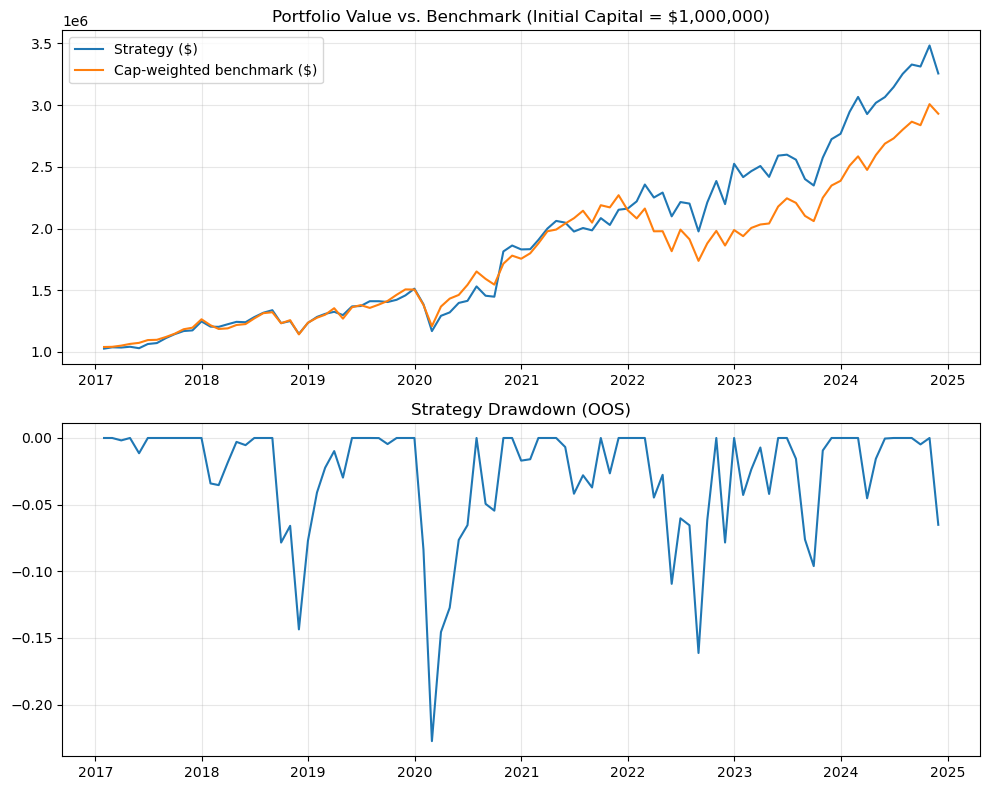

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================================
# CONFIG
# ===========================================
BACKTEST_START   = "2017-01-31"
BACKTEST_END     = "2024-12-31"
TOP_Q            = 0.20          # long top 20% by predicted excess return
TC_BPS           = 5             # round-trip cost in bps

META_COLS    = ['permno','date','mktcap_lag1','ticker','exchcd','siccd','shrcd']
SCORE_COL    = 'exp_excess_ret_1m'  # expected next-month excess return (will be created if missing)
TARGET_EXCESS= 'excess_ret_fwd_1m'  # realized next-month excess return
TARGET_TOTAL = 'ret_fwd_1m'         # realized next-month total return; if missing we reconstruct
RF_COL       = 'rf_1m'
INIT_CAPITAL = 1_000_000.0
REGIME_COL   = 'regime'             # 0/1 monthly label

# ------------- helpers used if we must build SCORE_COL -------------
def _month_key(s):
    return pd.to_datetime(s).dt.to_period("M").dt.to_timestamp("M")

def _cs_winsorize_zscore(g: pd.DataFrame, cols, p=0.01):
    out = g.copy()
    for c in cols:
        x = pd.to_numeric(out[c], errors="coerce").replace([np.inf, -np.inf], np.nan).astype(float)
        ql, qh = x.quantile([p, 1-p])
        x = x.clip(ql, qh)
        mu, sd = x.mean(), x.std(ddof=0)
        out[c + "_z"] = (x - mu) / sd if (sd and np.isfinite(sd) and sd > 0) else np.nan
    return out

def _month_first_non_na(s: pd.Series):
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) else pd.NA

def _ensure_six_factors(df):
    """Engineer the 6 cross-sectional factors if they don't already exist."""
    need_raw = ["ret","mktcap","dltt","dlc","che","oibdp","dp","revt","cogs","at","act","lct","volatility_daily"]
    miss = [c for c in need_raw if c not in df.columns]
    if miss:
        raise KeyError(f"Missing raw columns needed to build factors: {miss}")

    # Momentum (12–1): product of (1+ret) from t-12..t-2
    def momentum_12_1(group):
        rp1 = (1.0 + group["ret"].astype(float))
        rp1_shift1 = rp1.shift(1)  # exclude current month
        prod_12 = rp1_shift1.rolling(12, min_periods=12).apply(np.prod, raw=True)
        m_12_1 = prod_12 / rp1_shift1  # remove t-1 → keep t-12..t-2
        return m_12_1 - 1.0

    if "momentum_12m_ex1m" not in df.columns:
        df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)

    # Value (EBIT/EV): EBIT ≈ oibdp - dp; EV = mktcap + dltt + dlc - che
    if "value_ebit_ev" not in df.columns:
        df["ebit_bt"] = (df["oibdp"] - df["dp"]).astype(float)
        df["ev_bt"]   = (df["mktcap"] + df["dltt"].fillna(0) + df["dlc"].fillna(0) - df["che"].fillna(0)).astype(float)
        df.loc[df["ev_bt"] <= 0, "ev_bt"] = np.nan
        df["value_ebit_ev"] = df["ebit_bt"] / df["ev_bt"]

    # Profitability (Gross Profitability / Assets)
    if "profitability_gpa" not in df.columns:
        df["profitability_gpa"] = (df["revt"] - df["cogs"]) / df["at"]

    # Investment (Asset Growth): YoY
    if "investment_ag" not in df.columns:
        df["at_lag12_bt"] = df.groupby("permno")["at"].shift(12)
        df["investment_ag"] = (df["at"] - df["at_lag12_bt"]) / df["at_lag12_bt"]

    # Accruals (WC accruals / Assets)
    if "accruals" not in df.columns:
        for col in ["act", "che", "lct", "dlc", "dp"]:
            df[f"{col}_lag12_bt"] = df.groupby("permno")[col].shift(12)
        dACT = df["act"] - df["act_lag12_bt"]
        dCHE = df["che"] - df["che_lag12_bt"]
        dLCT = df["lct"] - df["lct_lag12_bt"]
        dDLC = df["dlc"] - df["dlc_lag12_bt"]
        dp_  = df["dp"]
        df["accruals"] = (dACT - dCHE - dLCT + dDLC - dp_) / df["at"]

    # Low-risk: use volatility_daily
    if "lowrisk_idio_vol" not in df.columns:
        df["lowrisk_idio_vol"] = df["volatility_daily"]

    FACTOR_COLS_SIX = [
        "momentum_12m_ex1m",
        "value_ebit_ev",
        "profitability_gpa",
        "investment_ag",
        "accruals",
        "lowrisk_idio_vol",
    ]
    return df, FACTOR_COLS_SIX

def _build_score_from_regime_premia(panel, beta_bar_by_regime, regime_col=REGIME_COL):
    """Compute exp_excess_ret_1m using per-regime premia and six engineered z-scored factors."""
    if regime_col not in panel.columns:
        raise KeyError(f"'{regime_col}' column is required to apply regime-specific premia.")

    # engineer factors if missing
    panel, FACTOR_COLS_SIX = _ensure_six_factors(panel)

    # z-score per month
    panel["_month"] = _month_key(panel["date"])
    panel = panel.groupby(panel["_month"], group_keys=False).apply(_cs_winsorize_zscore, cols=FACTOR_COLS_SIX)
    ZCOLS = [c + "_z" for c in FACTOR_COLS_SIX]

    # pick premia columns available (intersect)
    def predict_with_premia(g, premia):
        X_ = pd.DataFrame(index=g.index)
        X_["const"] = 1.0
        # align to intersection of premia index and built z-features
        cols = ["const"] + [c for c in ZCOLS if c in premia.index]
        X_ = X_.reindex(columns=cols).fillna(0.0)
        X_[cols[1:]] = g[cols[1:]]
        prem = premia.reindex(cols).fillna(0.0).values
        return pd.Series(np.dot(X_.values, prem), index=g.index)

    # compute per-month using that month's regime (first non-NA)
    monthly_regime = panel.groupby("_month")[regime_col].apply(_month_first_non_na)
    panel[SCORE_COL] = np.nan
    for m in monthly_regime.index:
        r = monthly_regime.loc[m]
        if pd.isna(r):
            continue
        r_eff = int(r)
        prem = beta_bar_by_regime.get(r_eff)
        if prem is None or prem.empty:
            continue
        idx = panel["_month"] == m
        g = panel.loc[idx]
        # need z-features present:
        if not all(c in g.columns for c in ZCOLS):
            continue
        panel.loc[idx, SCORE_COL] = predict_with_premia(g, prem).values

    panel = panel.drop(columns=["_month"], errors="ignore")
    return panel

# ===========================================
# 0) Prep panel & month keys
# ===========================================
panel = df_factor.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# If total forward return missing, reconstruct from excess + rf
if TARGET_TOTAL not in panel.columns and TARGET_EXCESS in panel.columns and RF_COL in panel.columns:
    panel[TARGET_TOTAL] = panel[TARGET_EXCESS] + panel[RF_COL]

# Build SCORE_COL on-the-fly if missing, using trained per-regime premia
if SCORE_COL not in panel.columns:
    if 'beta_bar_by_regime' not in globals():
        raise ValueError(
            f"Missing '{SCORE_COL}' and no 'beta_bar_by_regime' found. "
            "Train per-regime premia first and keep beta_bar_by_regime in scope."
        )
    panel = _build_score_from_regime_premia(panel, beta_bar_by_regime, regime_col=REGIME_COL)

# Now sanity-check required inputs
need_cols = [SCORE_COL, TARGET_EXCESS, RF_COL, 'mktcap_lag1']
missing = [c for c in need_cols if c not in panel.columns]
if missing:
    raise ValueError(f"Missing required columns in df_factor/panel: {missing}.")

# Use a 1-month execution lag on the score to avoid look-ahead
panel = panel.sort_values(['permno','month_eom'])
panel['score_lag1'] = panel.groupby('permno')[SCORE_COL].shift(1)

use_cols = list({*META_COLS, TARGET_EXCESS, TARGET_TOTAL, RF_COL, 'month_eom', 'score_lag1'})
panel = (panel[use_cols]
         .dropna(subset=[TARGET_EXCESS, 'mktcap_lag1'])
         .sort_values(['month_eom','permno'])
         .reset_index(drop=True))

# Backtest calendar
months = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months[(months >= pd.Timestamp(BACKTEST_START)) & (months <= pd.Timestamp(BACKTEST_END))]

# ===========================================
# 1) Cap-weighted benchmark (cap-weight on mktcap_lag1)
# ===========================================
_bench_base = panel[['month_eom','mktcap_lag1',TARGET_TOTAL]].dropna(subset=['mktcap_lag1', TARGET_TOTAL])

def _bench_func(g):
    total_mktcap = g['mktcap_lag1'].sum()
    if not np.isfinite(total_mktcap) or total_mktcap <= 0:
        return np.nan
    w = g['mktcap_lag1'] / total_mktcap
    return float(np.nansum(w.values * g[TARGET_TOTAL].values))

bench = (_bench_base.groupby('month_eom', sort=True)
         .apply(_bench_func).rename('bench_ret').reset_index()
         .rename(columns={'month_eom': 'date'}))

# monthly rf (assumed constant cross-sectionally)
rf_series = (panel.groupby('month_eom', as_index=False)[RF_COL]
                  .first()
                  .rename(columns={'month_eom': 'date'})[['date', RF_COL]])

# ===========================================
# 2) Helpers for stats
# ===========================================
def perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty:
        return {}
    exc = rets.copy()
    if rf is not None:
        rf_aligned = pd.Series(rf).reindex(rets.index).fillna(0.0)
        exc = rets - rf_aligned

    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)

    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)

    wealth = (1 + rets).cumprod()
    peak   = wealth.cummax()
    dd     = wealth/peak - 1.0
    maxdd  = dd.min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)

    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def rolling_ic(df_pred):
    if df_pred.empty:
        return {}, pd.Series(dtype=float)
    ics = (
        df_pred.groupby('month_eom')
               .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])
               .rename('IC')
               .dropna()
    )
    return {'IC mean': ics.mean(), 'IC std': ics.std(ddof=0),
            'IC IR': np.nan if ics.std(ddof=0)==0 else ics.mean()/ics.std(ddof=0)}, ics

# ===========================================
# 3) Walk-forward portfolio using lagged scores
# ===========================================
equity_curve = []
bench_curve  = []
turn_series  = []
pred_rows    = []
prev_w       = pd.Series(dtype=float)

for t in bt_months:
    tst = panel.loc[panel['month_eom'] == t].copy()

    # need lagged scores available to form the portfolio at t
    tst = tst.dropna(subset=['score_lag1'])
    if len(tst) == 0:
        continue

    # rank by lagged score (higher = better)
    pred = pd.Series(tst['score_lag1'].values, index=tst.index, name='pred')

    # Select top quantile
    if pred.notna().sum() == 0:
        continue
    cutoff = pred.quantile(1 - TOP_Q)
    sel_ix = pred.index[pred >= cutoff]
    if len(sel_ix) == 0:
        continue

    # Equal weight the selected names
    w = pd.Series(0.0, index=tst.index)
    w.loc[sel_ix] = 1.0 / len(sel_ix)

    # turnover (0.5 * L1 change)
    prev_aligned = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_aligned).sum()
    turn_series.append((t, float(turn)))
    prev_w = w.copy()

    # realized next-month returns
    y_ex = panel.loc[w.index, TARGET_EXCESS].astype(float)
    y_to = panel.loc[w.index, TARGET_TOTAL].astype(float)

    # rf for month t
    rf_t = rf_series.loc[rf_series['date']==t, RF_COL]
    rf_t = float(rf_t.squeeze()) if len(rf_t) else 0.0

    # trading cost & performance
    cost = turn * (TC_BPS / 10000.0)
    port_excess = float(np.nansum(w.values * y_ex.values)) - cost
    port_total  = rf_t + port_excess

    equity_curve.append((t, port_total))

    b = bench.loc[bench['date']==t, 'bench_ret']
    bench_curve.append((t, float(b.squeeze()) if len(b) else np.nan))

    # store for IC
    pred_rows.append(pd.DataFrame({
        'month_eom': panel.loc[w.index, 'month_eom'].values,
        'pred'     : pred.loc[w.index].values,
        'y'        : y_ex.values
    }))

# ===========================================
# 4) Series & metrics
# ===========================================
eq = pd.Series({d:r for d,r in equity_curve}).sort_index()
bm = pd.Series({d:r for d,r in bench_curve}).sort_index()
to = pd.Series({d:v for d,v in turn_series}).sort_index()

common = eq.index.intersection(bm.index)
eq = eq.reindex(common)
bm = bm.reindex(common)

eq_cum = (1 + eq).cumprod()
bm_cum = (1 + bm).cumprod()

perf       = perf_stats(eq, rf_series.set_index('date')[RF_COL])
bench_perf = perf_stats(bm, rf_series.set_index('date')[RF_COL])

# Tracking error & IR
active = (eq - bm).dropna()
TE = active.std(ddof=0) * np.sqrt(12)
IR = np.nan if active.std(ddof=0)==0 else active.mean()/active.std(ddof=0) * np.sqrt(12)

# Alpha/Beta (OLS on total returns)
X = np.vstack([np.ones(len(bm)), bm.values]).T
beta_hat = np.linalg.lstsq(X, eq.values, rcond=None)[0]
alpha_m, beta_ = beta_hat[0], beta_hat[1]
alpha_a = (1 + alpha_m)**12 - 1

# IC diagnostics
pred_df = pd.concat(pred_rows, ignore_index=True) if len(pred_rows) else pd.DataFrame(columns=['month_eom','pred','y'])
ic_stats, ic_series = rolling_ic(pred_df)
avg_turn = to.mean() if len(to) else np.nan

def pct(x): 
    return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

print("OOS Backtest (monthly, no look-ahead; score lagged 1m)")
if not eq.empty:
    print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")
print("Strategy |",
      "CAGR", pct(perf.get('CAGR', np.nan)),
      "Vol", pct(perf.get('Vol', np.nan)),
      "Sharpe", f"{perf.get('Sharpe', np.nan):.3f}" if pd.notna(perf.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{perf.get('Sortino', np.nan):.3f}" if pd.notna(perf.get('Sortino', np.nan)) else "n/a",
      "MaxDD", pct(perf.get('MaxDD', np.nan)),
      "Calmar", f"{perf.get('Calmar', np.nan):.3f}" if pd.notna(perf.get('Calmar', np.nan)) else "n/a",
      "Hit", f"{perf.get('Hit', np.nan):.3f}" if pd.notna(perf.get('Hit', np.nan)) else "n/a",
      "AvgTurn", f"{avg_turn:.3f}" if pd.notna(avg_turn) else "n/a")
print("Benchmark|",
      "CAGR", pct(bench_perf.get('CAGR', np.nan)),
      "Vol", pct(bench_perf.get('Vol', np.nan)),
      "Sharpe", f"{bench_perf.get('Sharpe', np.nan):.3f}" if pd.notna(bench_perf.get('Sharpe', np.nan)) else "n/a",
      "MaxDD", pct(bench_perf.get('MaxDD', np.nan)))
print("Relative|",
      "Alpha_ann", pct(alpha_a),
      "Beta", f"{beta_:.3f}",
      "TE", f"{TE:.3f}",
      "IR", f"{IR:.3f}")
if ic_stats:
    print("IC diagnostics (OOS):",
          f"IC mean {ic_stats['IC mean']:.4f}, IC std {ic_stats['IC std']:.4f}, IC IR {ic_stats['IC IR']:.4f}")

# ===========================================
# 5) Plot: Equity vs Benchmark + Drawdown
# ===========================================
eq_dollar = INIT_CAPITAL * eq_cum
bm_dollar = INIT_CAPITAL * bm_cum
dd = eq_dollar/eq_dollar.cummax() - 1.0

plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
ax1.plot(bm_dollar.index, bm_dollar.values, label='Cap-weighted benchmark ($)')
ax1.set_title(f"Portfolio Value vs. Benchmark (Initial Capital = ${INIT_CAPITAL:,.0f})")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2,1,2)
ax2.plot(dd.index, dd.values)
ax2.set_title("Strategy Drawdown (OOS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


factor model trained per regime, ranked based on expected excess return and then longed top 30 stocks proportional to their excess return

C:\Users\woota\AppData\Local\Temp\ipykernel_40392\2016343681.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)
C:\Users\woota\AppData\Local\Temp\ipykernel_40392\2016343681.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby(panel["_month"], group_keys=False).apply(_cs_winsorize_zscore, cols=FACTOR

OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy | CAGR +17.79% Vol +21.65% Sharpe 0.863 Sortino 1.555 MaxDD -20.26% Calmar 0.878 Hit 0.632 AvgTurn 0.500
Benchmark| CAGR +14.55% Vol +16.23% Sharpe 0.922 MaxDD -23.44%
Relative| Alpha_ann +3.76% Beta 1.002 TE 0.143 IR 0.261
IC diagnostics (OOS): IC mean 0.0181, IC std 0.1927, IC IR 0.0938


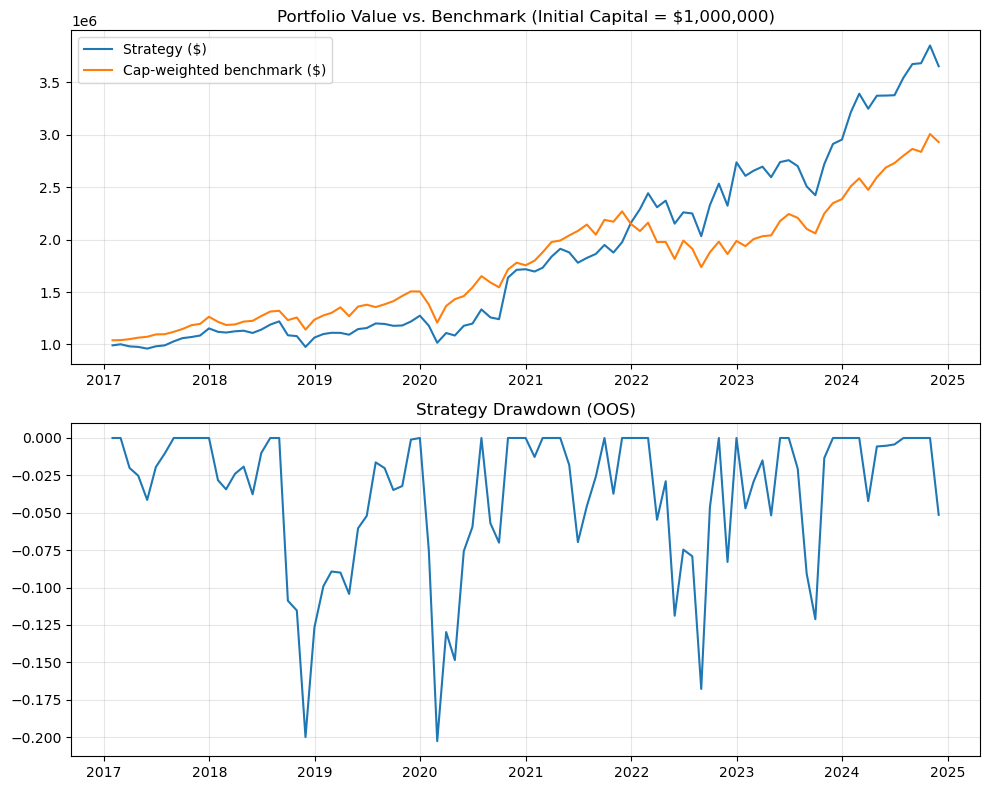

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================================
# CONFIG
# ===========================================
BACKTEST_START   = "2017-01-31"
BACKTEST_END     = "2024-12-31"
TOP_K            = 30            # <-- pick exactly 30 stocks each month
TC_BPS           = 5             # round-trip cost in bps

META_COLS    = ['permno','date','mktcap_lag1','ticker','exchcd','siccd','shrcd']
SCORE_COL    = 'exp_excess_ret_1m'  # expected next-month excess return (lagged for trading)
TARGET_EXCESS= 'excess_ret_fwd_1m'  # realized next-month excess return
TARGET_TOTAL = 'ret_fwd_1m'         # realized next-month total return; if missing we reconstruct
RF_COL       = 'rf_1m'
INIT_CAPITAL = 1_000_000.0

# ---------- (optional) helpers only if you sometimes lack SCORE_COL ----------
def _month_key(s):
    return pd.to_datetime(s).dt.to_period("M").dt.to_timestamp("M")

def _cs_winsorize_zscore(g: pd.DataFrame, cols, p=0.01):
    out = g.copy()
    for c in cols:
        x = pd.to_numeric(out[c], errors="coerce").replace([np.inf, -np.inf], np.nan).astype(float)
        ql, qh = x.quantile([p, 1-p])
        x = x.clip(ql, qh)
        mu, sd = x.mean(), x.std(ddof=0)
        out[c + "_z"] = (x - mu) / sd if (sd and np.isfinite(sd) and sd > 0) else np.nan
    return out

def _month_first_non_na(s: pd.Series):
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) else pd.NA

def _ensure_six_factors(df):
    need_raw = ["ret","mktcap","dltt","dlc","che","oibdp","dp","revt","cogs","at","act","lct","volatility_daily"]
    miss = [c for c in need_raw if c not in df.columns]
    if miss:
        raise KeyError(f"Missing raw columns needed to build factors: {miss}")

    def momentum_12_1(group):
        rp1 = (1.0 + group["ret"].astype(float))
        rp1_shift1 = rp1.shift(1)
        prod_12 = rp1_shift1.rolling(12, min_periods=12).apply(np.prod, raw=True)
        m_12_1 = prod_12 / rp1_shift1
        return m_12_1 - 1.0

    if "momentum_12m_ex1m" not in df.columns:
        df["momentum_12m_ex1m"] = df.groupby("permno", group_keys=False).apply(momentum_12_1)
    if "value_ebit_ev" not in df.columns:
        df["ebit_bt"] = (df["oibdp"] - df["dp"]).astype(float)
        df["ev_bt"]   = (df["mktcap"] + df["dltt"].fillna(0) + df["dlc"].fillna(0) - df["che"].fillna(0)).astype(float)
        df.loc[df["ev_bt"] <= 0, "ev_bt"] = np.nan
        df["value_ebit_ev"] = df["ebit_bt"] / df["ev_bt"]
    if "profitability_gpa" not in df.columns:
        df["profitability_gpa"] = (df["revt"] - df["cogs"]) / df["at"]
    if "investment_ag" not in df.columns:
        df["at_lag12_bt"] = df.groupby("permno")["at"].shift(12)
        df["investment_ag"] = (df["at"] - df["at_lag12_bt"]) / df["at_lag12_bt"]
    if "accruals" not in df.columns:
        for col in ["act", "che", "lct", "dlc", "dp"]:
            df[f"{col}_lag12_bt"] = df.groupby("permno")[col].shift(12)
        dACT = df["act"] - df["act_lag12_bt"]
        dCHE = df["che"] - df["che_lag12_bt"]
        dLCT = df["lct"] - df["lct_lag12_bt"]
        dDLC = df["dlc"] - df["dlc_lag12_bt"]
        dp_  = df["dp"]
        df["accruals"] = (dACT - dCHE - dLCT + dDLC - dp_) / df["at"]
    if "lowrisk_idio_vol" not in df.columns:
        df["lowrisk_idio_vol"] = df["volatility_daily"]

    FACTOR_COLS_SIX = [
        "momentum_12m_ex1m",
        "value_ebit_ev",
        "profitability_gpa",
        "investment_ag",
        "accruals",
        "lowrisk_idio_vol",
    ]
    return df, FACTOR_COLS_SIX

def _build_score_from_regime_premia(panel, beta_bar_by_regime, regime_col='regime'):
    if regime_col not in panel.columns:
        raise KeyError(f"'{regime_col}' column is required to apply regime-specific premia.")
    panel, FACTOR_COLS_SIX = _ensure_six_factors(panel)
    panel["_month"] = _month_key(panel["date"])
    panel = panel.groupby(panel["_month"], group_keys=False).apply(_cs_winsorize_zscore, cols=FACTOR_COLS_SIX)
    ZCOLS = [c + "_z" for c in FACTOR_COLS_SIX]

    def predict_with_premia(g, premia):
        X_ = pd.DataFrame(index=g.index)
        X_["const"] = 1.0
        cols = ["const"] + [c for c in ZCOLS if c in premia.index]
        X_ = X_.reindex(columns=cols).fillna(0.0)
        X_[cols[1:]] = g[cols[1:]]
        prem = premia.reindex(cols).fillna(0.0).values
        return pd.Series(np.dot(X_.values, prem), index=g.index)

    monthly_regime = panel.groupby("_month")[regime_col].apply(_month_first_non_na)
    panel[SCORE_COL] = np.nan
    for m in monthly_regime.index:
        r = monthly_regime.loc[m]
        if pd.isna(r): 
            continue
        r_eff = int(r)
        prem  = beta_bar_by_regime.get(r_eff)
        if prem is None or prem.empty: 
            continue
        idx = panel["_month"] == m
        g = panel.loc[idx]
        panel.loc[idx, SCORE_COL] = predict_with_premia(g, prem).values

    panel = panel.drop(columns=["_month"], errors="ignore")
    return panel

# ===========================================
# 0) Prep panel & month keys
# ===========================================
panel = df_factor.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# If total forward return missing, reconstruct from excess + rf
if TARGET_TOTAL not in panel.columns and TARGET_EXCESS in panel.columns and RF_COL in panel.columns:
    panel[TARGET_TOTAL] = panel[TARGET_EXCESS] + panel[RF_COL]

# Build SCORE_COL on-the-fly if missing, using trained per-regime premia
if SCORE_COL not in panel.columns:
    if 'beta_bar_by_regime' not in globals():
        raise ValueError(
            f"Missing '{SCORE_COL}' and no 'beta_bar_by_regime' found. "
            "Train per-regime premia first and keep beta_bar_by_regime in scope."
        )
    panel = _build_score_from_regime_premia(panel, beta_bar_by_regime, regime_col='regime')

# Sanity: need score and targets
need_cols = [SCORE_COL, TARGET_EXCESS, RF_COL, 'mktcap_lag1']
missing = [c for c in need_cols if c not in panel.columns]
if missing:
    raise ValueError(f"Missing required columns in df_factor/panel: {missing}.")

# Use a 1-month execution lag on the score to avoid look-ahead
panel = panel.sort_values(['permno','month_eom'])
panel['score_lag1'] = panel.groupby('permno')[SCORE_COL].shift(1)

use_cols = list({*META_COLS, TARGET_EXCESS, TARGET_TOTAL, RF_COL, 'month_eom', 'score_lag1'})
panel = (panel[use_cols]
         .dropna(subset=[TARGET_EXCESS, 'mktcap_lag1'])
         .sort_values(['month_eom','permno'])
         .reset_index(drop=True))

# Backtest calendar
months = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months[(months >= pd.Timestamp(BACKTEST_START)) & (months <= pd.Timestamp(BACKTEST_END))]

# ===========================================
# 1) Cap-weighted benchmark (cap-weight on mktcap_lag1)
# ===========================================
_bench_base = panel[['month_eom','mktcap_lag1',TARGET_TOTAL]].dropna(subset=['mktcap_lag1', TARGET_TOTAL])

def _bench_func(g):
    total_mktcap = g['mktcap_lag1'].sum()
    if not np.isfinite(total_mktcap) or total_mktcap <= 0:
        return np.nan
    w = g['mktcap_lag1'] / total_mktcap
    return float(np.nansum(w.values * g[TARGET_TOTAL].values))

bench = (_bench_base.groupby('month_eom', sort=True)
         .apply(_bench_func).rename('bench_ret').reset_index()
         .rename(columns={'month_eom': 'date'}))

# monthly rf (assumed constant cross-sectionally)
rf_series = (panel.groupby('month_eom', as_index=False)[RF_COL]
                  .first()
                  .rename(columns={'month_eom': 'date'})[['date', RF_COL]])

# ===========================================
# 2) Helpers for stats
# ===========================================
def perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty:
        return {}
    exc = rets.copy()
    if rf is not None:
        rf_aligned = pd.Series(rf).reindex(rets.index).fillna(0.0)
        exc = rets - rf_aligned

    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)

    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)

    wealth = (1 + rets).cumprod()
    peak   = wealth.cummax()
    dd     = wealth/peak - 1.0
    maxdd  = dd.min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)

    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def rolling_ic(df_pred):
    if df_pred.empty:
        return {}, pd.Series(dtype=float)
    ics = (
        df_pred.groupby('month_eom')
               .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])
               .rename('IC')
               .dropna()
    )
    return {'IC mean': ics.mean(), 'IC std': ics.std(ddof=0),
            'IC IR': np.nan if ics.std(ddof=0)==0 else ics.mean()/ics.std(ddof=0)}, ics

# ===========================================
# 3) Walk-forward portfolio: TOP_K + score-proportional weights
# ===========================================
equity_curve = []
bench_curve  = []
turn_series  = []
pred_rows    = []
prev_w       = pd.Series(dtype=float)

for t in bt_months:
    tst = panel.loc[panel['month_eom'] == t].copy()

    # need lagged scores to form the portfolio at t
    tst = tst.dropna(subset=['score_lag1'])
    if len(tst) == 0:
        continue

    # rank by lagged score (higher = better)
    pred = pd.Series(tst['score_lag1'].values, index=tst.index, name='pred')

    # pick top K by score
    pred_non_na = pred.dropna()
    if pred_non_na.empty:
        continue
    sel_ix = pred_non_na.sort_values(ascending=False).head(TOP_K).index

    # Score-proportional weights (clip negatives, normalize). Fallback to equal-weight.
    w = pd.Series(0.0, index=tst.index)
    sel_scores = pred.loc[sel_ix].clip(lower=0)  # nonnegative weights
    if sel_scores.sum() > 0:
        w.loc[sel_ix] = sel_scores / sel_scores.sum()
    else:
        w.loc[sel_ix] = 1.0 / len(sel_ix)

    # turnover (0.5 * L1 change)
    prev_aligned = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_aligned).sum()
    turn_series.append((t, float(turn)))
    prev_w = w.copy()

    # realized next-month returns
    y_ex = panel.loc[w.index, TARGET_EXCESS].astype(float)
    y_to = panel.loc[w.index, TARGET_TOTAL].astype(float)

    # rf for month t
    rf_t = rf_series.loc[rf_series['date']==t, RF_COL]
    rf_t = float(rf_t.squeeze()) if len(rf_t) else 0.0

    # trading cost & performance
    cost = turn * (TC_BPS / 10000.0)
    port_excess = float(np.nansum(w.values * y_ex.values)) - cost
    port_total  = rf_t + port_excess

    equity_curve.append((t, port_total))

    b = bench.loc[bench['date']==t, 'bench_ret']
    bench_curve.append((t, float(b.squeeze()) if len(b) else np.nan))

    # store for IC
    pred_rows.append(pd.DataFrame({
        'month_eom': panel.loc[w.index, 'month_eom'].values,
        'pred'     : pred.loc[w.index].values,
        'y'        : y_ex.values
    }))

# ===========================================
# 4) Series & metrics
# ===========================================
eq = pd.Series({d:r for d,r in equity_curve}).sort_index()
bm = pd.Series({d:r for d,r in bench_curve}).sort_index()
to = pd.Series({d:v for d,v in turn_series}).sort_index()

common = eq.index.intersection(bm.index)
eq = eq.reindex(common)
bm = bm.reindex(common)

eq_cum = (1 + eq).cumprod()
bm_cum = (1 + bm).cumprod()

perf       = perf_stats(eq, rf_series.set_index('date')[RF_COL])
bench_perf = perf_stats(bm, rf_series.set_index('date')[RF_COL])

# Tracking error & IR
active = (eq - bm).dropna()
TE = active.std(ddof=0) * np.sqrt(12)
IR = np.nan if active.std(ddof=0)==0 else active.mean()/active.std(ddof=0) * np.sqrt(12)

# Alpha/Beta (OLS on total returns)
X = np.vstack([np.ones(len(bm)), bm.values]).T
beta_hat = np.linalg.lstsq(X, eq.values, rcond=None)[0]
alpha_m, beta_ = beta_hat[0], beta_hat[1]
alpha_a = (1 + alpha_m)**12 - 1

# IC diagnostics
pred_df = pd.concat(pred_rows, ignore_index=True) if len(pred_rows) else pd.DataFrame(columns=['month_eom','pred','y'])
ic_stats, ic_series = rolling_ic(pred_df)
avg_turn = to.mean() if len(to) else np.nan

def pct(x): 
    return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

print("OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)")
if not eq.empty:
    print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")
print("Strategy |",
      "CAGR", pct(perf.get('CAGR', np.nan)),
      "Vol", pct(perf.get('Vol', np.nan)),
      "Sharpe", f"{perf.get('Sharpe', np.nan):.3f}" if pd.notna(perf.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{perf.get('Sortino', np.nan):.3f}" if pd.notna(perf.get('Sortino', np.nan)) else "n/a",
      "MaxDD", pct(perf.get('MaxDD', np.nan)),
      "Calmar", f"{perf.get('Calmar', np.nan):.3f}" if pd.notna(perf.get('Calmar', np.nan)) else "n/a",
      "Hit", f"{perf.get('Hit', np.nan):.3f}" if pd.notna(perf.get('Hit', np.nan)) else "n/a",
      "AvgTurn", f"{avg_turn:.3f}" if pd.notna(avg_turn) else "n/a")
print("Benchmark|",
      "CAGR", pct(bench_perf.get('CAGR', np.nan)),
      "Vol", pct(bench_perf.get('Vol', np.nan)),
      "Sharpe", f"{bench_perf.get('Sharpe', np.nan):.3f}" if pd.notna(bench_perf.get('Sharpe', np.nan)) else "n/a",
      "MaxDD", pct(bench_perf.get('MaxDD', np.nan)))
print("Relative|",
      "Alpha_ann", pct(alpha_a),
      "Beta", f"{beta_:.3f}",
      "TE", f"{TE:.3f}",
      "IR", f"{IR:.3f}")
if ic_stats:
    print("IC diagnostics (OOS):",
          f"IC mean {ic_stats['IC mean']:.4f}, IC std {ic_stats['IC std']:.4f}, IC IR {ic_stats['IC IR']:.4f}")

# ===========================================
# 5) Plot: Equity vs Benchmark + Drawdown
# ===========================================
eq_dollar = INIT_CAPITAL * eq_cum
bm_dollar = INIT_CAPITAL * bm_cum
dd = eq_dollar/eq_dollar.cummax() - 1.0

plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
ax1.plot(bm_dollar.index, bm_dollar.values, label='Cap-weighted benchmark ($)')
ax1.set_title(f"Portfolio Value vs. Benchmark (Initial Capital = ${INIT_CAPITAL:,.0f})")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2,1,2)
ax2.plot(dd.index, dd.values)
ax2.set_title("Strategy Drawdown (OOS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
